# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [40]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [41]:
# Use this space for any additional import statements you need



In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0.0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        common_tokens = Counter(tokens).most_common(num_tokens)
        print("Most common tokens:")
        for token, count in common_tokens:
            print(f"{token}: {count}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [token for token in tokens if token.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return whitespace_pattern.split(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here

# Initialize an empty DataFrame for lyrics data
lyrics_data = []

# Iterate through the lyrics folder and read the files
for artist in artist_files.keys():
    artist_lyrics_dir = os.path.join(data_location, lyrics_folder, artist)
    if os.path.exists(artist_lyrics_dir):
        print(f"Reading lyrics from directory: {artist_lyrics_dir}")  # Debugging information
        artist_lyrics = ""
        for file_name in os.listdir(artist_lyrics_dir):
            file_path = os.path.join(artist_lyrics_dir, file_name)
            if os.path.isfile(file_path):
                with open(file_path, 'r', encoding='utf-8') as file:
                    artist_lyrics += file.read() + "\n"
        lyrics_data.append({'artist': artist, 'lyrics': artist_lyrics})
    else:
        print(f"Directory not found: {artist_lyrics_dir}")

# Convert the lyrics data to a DataFrame
lyrics_df = pd.DataFrame(lyrics_data)

# Display the first few rows of the lyrics DataFrame
print(lyrics_df.head())


Reading lyrics from directory: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/lyrics/cher
Reading lyrics from directory: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/lyrics/robyn
  artist                                             lyrics
0   cher  "Come And Stay With Me"\n\n\n\nI'll send away ...
1  robyn  "Include Me Out"\n\n\n\nIt is really very simp...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# pipeline to the lyrics data
lyrics_df["tokens"] = lyrics_df["lyrics"].apply(prepare, pipeline=my_pipeline)
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len)

# pipeline to the Twitter data
twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

# Display the first few of the processed data
print(lyrics_df.head())
print(twitter_data.head())


  artist                                             lyrics  \
0   cher  "Come And Stay With Me"\n\n\n\nI'll send away ...   
1  robyn  "Include Me Out"\n\n\n\nIt is really very simp...   

                                              tokens  num_tokens  
0  [come, stay, ill, send, away, false, pride, il...       35917  
1  [include, really, simple, single, pulse, repea...       15228  
    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  1496463006451974150             NaN   
3  gallionjenna             J           3366479914             NaN   
4       bcscomm       bcscomm             83915043  Washington, DC   

   followers_count  friends_count  \
0             1302           1014   
1               81            514   
2               13            140   
3              752            556   
4  

In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3962842,cher,poet/scholar/believer • BREATHE (Central Squar...,"[poetscholarbeliever, •, breathe, central, squ..."
1950510,cher,Blissfully Married ♥️ Mommy 🥰 Owner of BC Desi...,"[blissfully, married, ♥️, mommy, 🥰, owner, bc,..."
2509307,cher,Interior Designer ✨ New York / Atlanta / New O...,"[interior, designer, ✨, new, york, atlanta, ne..."
529052,cher,Madre of 2 . Wifey of 1 amazing hubby Daniel ❤...,"[madre, 2, wifey, 1, amazing, hubby, daniel, ❤..."
1840679,cher,24 years old. AW 18-03-16👫 Instagram- francesc...,"[24, years, old, aw, 180316👫, instagram, franc..."
3733647,cher,"Backwoods legit , don't take no shit!!!!☠️☠️☠️...","[backwoods, legit, dont, take, shit☠️☠️☠️☠️☠️🧟..."
65963,cher,"Shy, Atheist, Ginger. Carer for my disabled da...","[shy, atheist, ginger, carer, disabled, daught..."
2388150,cher,British✌️Instagram @gemma_barton_,"[british✌️instagram, gemmabarton]"
1208174,cher,me/myself/gem-in-i. INFP. poetry. stories. scr...,"[memyselfgemini, infp, poetry, stories, script..."
2930846,cher,Woman Marketer 💃🏻 Network Marketing 🙋🏼‍♀️ Drea...,"[woman, marketer, 💃🏻, network, marketing, 🙋🏼‍♀..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One potential area for improvement in the tokenization process is the handling of compound words and phrases, such as named entities and common multi-word expressions.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
# your code here
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a dictionary with these statistics.
    """
    num_tokens_total = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens_total if num_tokens_total > 0 else 0
    most_common_tokens = Counter(tokens).most_common(num_tokens)
    
    stats = {
        'num_tokens': num_tokens_total,
        'num_unique_tokens': num_unique_tokens,
        'num_characters': num_characters,
        'lexical_diversity': lexical_diversity,
        'most_common_tokens': most_common_tokens
    }
    
    if verbose:
        print(f"Number of tokens: {num_tokens_total}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.2f}")
        print(f"Most common tokens: {most_common_tokens}")
    
    return stats

# text processing pipeline
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Apply the pipeline to lyrics data
lyrics_df["tokens"] = lyrics_df["lyrics"].apply(lambda x: prepare(x, my_pipeline))
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len)

# Calculate descriptive statistics for each artist
for artist in lyrics_df["artist"].unique():
    print(f"\nDescriptive statistics for {artist}:")
    artist_tokens = lyrics_df[lyrics_df["artist"] == artist]["tokens"].sum()
    artist_stats = descriptive_stats(artist_tokens)

# If needed, store the statistics for further comparison
artist_stats_dict = {}
for artist in lyrics_df["artist"].unique():
    artist_tokens = lyrics_df[lyrics_df["artist"] == artist]["tokens"].sum()
    artist_stats_dict[artist] = descriptive_stats(artist_tokens, verbose=False)

# Compare the results
print("\nComparison of descriptive statistics:")
for artist, stats in artist_stats_dict.items():
    print(f"\n{artist}:")
    for stat, value in stats.items():
        if stat == 'most_common_tokens':
            value = ", ".join([f"{token} ({count})" for token, count in value])
        print(f"{stat}: {value}")



Descriptive statistics for cher:
Number of tokens: 35917
Number of unique tokens: 3704
Number of characters: 172634
Lexical diversity: 0.10
Most common tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]

Descriptive statistics for robyn:
Number of tokens: 15228
Number of unique tokens: 2157
Number of characters: 73787
Lexical diversity: 0.14
Most common tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]

Comparison of descriptive statistics:

cher:
num_tokens: 35917
num_unique_tokens: 3704
num_characters: 172634
lexical_diversity: 0.10312665311690843
most_common_tokens: love (1004), im (513), know (486), dont (440), youre (333)

robyn:
num_tokens: 15228
num_unique_tokens: 2157
num_characters: 73787
lexical_diversity: 0.14164696611505123
most_common_tokens: know (308), dont (301), im (299), love (275), got (251)


Q: what observations do you make about these data? 

A: In summary, Cher's lyrics feature a larger volume with more repetitive use of words, while Robyn's lyrics, although smaller in size, exhibit greater lexical variety. Both artists share common themes in their most frequently used words, reflecting typical subject matter in pop and lyrical music. These observations emphasize the stylistic differences between the two artists in terms of lyrical composition and vocabulary usage.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [12]:
# your code here
data_location = "/Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/"
lyrics_folder = "lyrics/"
twitter_folder = "twitter/"

# Function to read files from a directory
def read_files_from_directory(directory):
    text_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                text_data.append(file.read())
    return text_data

# Read lyrics data
lyrics_data = {
    "cher": read_files_from_directory(data_location + lyrics_folder + "cher/"),
    "robyn": read_files_from_directory(data_location + lyrics_folder + "robyn/")
}

# Function to read a single file
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Read Twitter data from individual files
twitter_data = {
    "cher": [read_file(data_location + twitter_folder + artist_files['cher'])],
    "robyn": [read_file(data_location + twitter_folder + artist_files['robyn'])]
}

# Define necessary functions and constants
tw_punct = set(punctuation) - {"#"}
sw = set(stopwords.words("english"))
whitespace_pattern = re.compile(r"\s+")

def remove_stop(tokens):
    return [token for token in tokens if token not in sw]

def remove_punctuation(text, punct_set=tw_punct):
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    return whitespace_pattern.split(text)

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

def calculate_frequencies_and_concentrations(tokens):
    token_counts = Counter(tokens)
    total_tokens = sum(token_counts.values())
    concentrations = {token: count / total_tokens for token, count in token_counts.items()}
    return token_counts, concentrations

def find_unique_tokens(token_counts_cher, token_counts_robyn, min_occurrences=5):
    unique_tokens = []
    all_tokens = set(token_counts_cher.keys()).union(set(token_counts_robyn.keys()))
    for token in all_tokens:
        if token_counts_cher.get(token, 0) >= min_occurrences and token_counts_robyn.get(token, 0) >= min_occurrences:
            cher_concentration = token_counts_cher[token] / sum(token_counts_cher.values())
            robyn_concentration = token_counts_robyn[token] / sum(token_counts_robyn.values())
            if robyn_concentration != 0:
                ratio = cher_concentration / robyn_concentration
                unique_tokens.append((token, ratio))
    unique_tokens = sorted(unique_tokens, key=lambda item: item[1], reverse=True)[:10]
    return [token for token, ratio in unique_tokens]

# Apply the pipeline to lyrics and Twitter data
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Function to prepare and concatenate all lyrics or descriptions
def prepare_and_concatenate(text_list, pipeline):
    all_tokens = []
    for text in text_list:
        all_tokens.extend(prepare(text, pipeline))
    return all_tokens

# Apply the pipeline and concatenate
lyrics_tokens = {artist: prepare_and_concatenate(lyrics, my_pipeline) for artist, lyrics in lyrics_data.items()}
twitter_tokens = {artist: prepare_and_concatenate(descriptions, my_pipeline) for artist, descriptions in twitter_data.items()}

# Calculate token frequencies and concentrations
lyrics_counts_cher, lyrics_concentrations_cher = calculate_frequencies_and_concentrations(lyrics_tokens["cher"])
lyrics_counts_robyn, lyrics_concentrations_robyn = calculate_frequencies_and_concentrations(lyrics_tokens["robyn"])

twitter_counts_cher, twitter_concentrations_cher = calculate_frequencies_and_concentrations(twitter_tokens["cher"])
twitter_counts_robyn, twitter_concentrations_robyn = calculate_frequencies_and_concentrations(twitter_tokens["robyn"])

# Find unique tokens
unique_lyrics_cher = find_unique_tokens(lyrics_counts_cher, lyrics_counts_robyn)
unique_lyrics_robyn = find_unique_tokens(lyrics_counts_robyn, lyrics_counts_cher)

unique_twitter_cher = find_unique_tokens(twitter_counts_cher, twitter_counts_robyn)
unique_twitter_robyn = find_unique_tokens(twitter_counts_robyn, twitter_counts_cher)

# Print results
print("Top 10 tokens uniquely related to Cher (lyrics):", unique_lyrics_cher)
print("Top 10 tokens uniquely related to Robyn (lyrics):", unique_lyrics_robyn)
print("Top 10 tokens uniquely related to Cher (twitter):", unique_twitter_cher)
print("Top 10 tokens uniquely related to Robyn (twitter):", unique_twitter_robyn)

Top 10 tokens uniquely related to Cher (lyrics): ['walk', 'find', 'enough', 'man', 'without', 'strong', 'live', 'believe', 'tears', 'name']
Top 10 tokens uniquely related to Robyn (lyrics): ['beat', 'dance', 'work', 'hang', 'forgive', 'alright', 'shake', 'party', 'pretend', 'space']
Top 10 tokens uniquely related to Cher (twitter): ['grandmother', '#fbr', '#resister', 'resister', 'armenia', 'darlene', 'rbsoul', 'rhonda', '#theresistance', 'hiphoprap']
Top 10 tokens uniquely related to Robyn (twitter): ['vänner', 'axelsson', 'hampus', 'sveriges', 'bäst', 'träning', 'håkan', 'göran', 'följ', 'fransson']


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Cher's lyrics focus on personal empowerment and emotional experiences, while Robyn's lyrics reflect a vibrant, dance-oriented, and emotionally resilient theme. On Twitter, Cher engages in political activism and social issues, with occasional personal references. On the other hand, Robyn's Twitter highlights her personal life, fitness, and Swedish cultural context, with mentions of friends and public figures. I noticed that included words that have accent marks on the list. Robyn's twitter tend to have non-english words.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


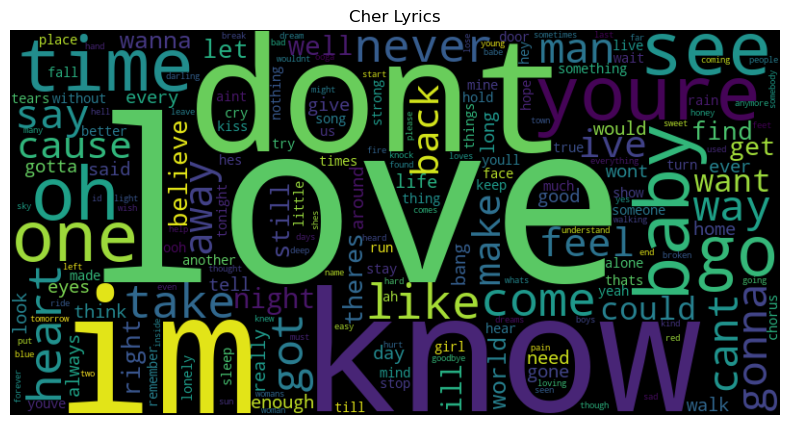

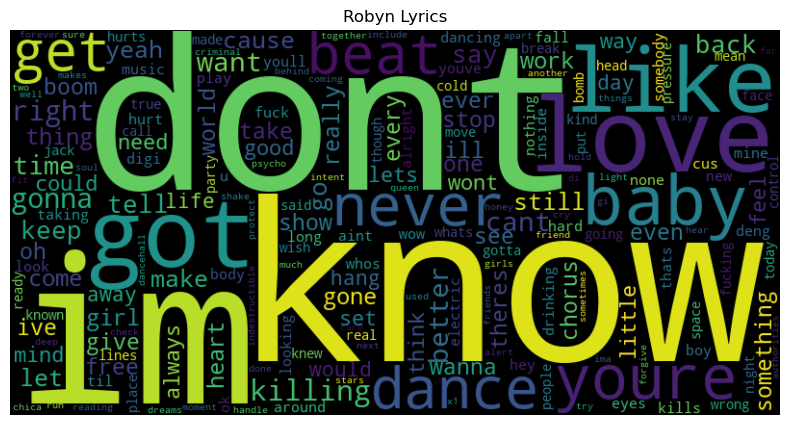

In [48]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

# Function to generate word clouds
def wordcloud(word_freq, title=None, max_words=200):
    wc = WordCloud(width=800, height=400, max_words=max_words).generate_from_frequencies(word_freq.to_dict()['freq'])
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()
    
# Count word frequencies for Cher and Robyn's lyrics
cher_lyrics_freq = count_words(lyrics_df[lyrics_df['artist'] == 'cher'], column='tokens')
robyn_lyrics_freq = count_words(lyrics_df[lyrics_df['artist'] == 'robyn'], column='tokens')


# Generate word clouds for Cher and Robyn's lyrics
wordcloud(cher_lyrics_freq, title='Cher Lyrics')
wordcloud(robyn_lyrics_freq, title='Robyn Lyrics')


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Words that are more frequent tends to be bigger in text.